# What brings more revenue

I stepped into a role of an analyst for a telecom operator called Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue, in order to adjust the advertising budget. 

## Content <a id='content'></a>

[Introduction](#intro)

[Dataset](#dataset)

[Data overview](#data_overview)

[Data preprocessing](#preprocessing)

[EDA](#eda)

[SDA](#sda)

[Summary and conclusions](#conclusions)

## Introduction <a id = "intro"> <a/>

The ultimate goal stated for the project is to determine which prepaid plan brings in more revenue for the company; thus, we are going to analyze clients' behavior and determine which prepaid plan generates more revenue.

We were provided with data on the plans themselves and a relatively small client selection, 500 users, and their mobile traffic in 2018: calls, messages, web sessions. Thus, we are going to carry out the analysis of the plans based on who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent.

We have not been provided with any preliminary hypothesis or information regarding the data quality; therefore, we will have to carefully study the data, evaluate its quality and see how significant its issues are and what are appropriate ways to fix them. It will be safe to assume that the project will involve some data preprocessing: we account for the most critical problems (identify and fill in missing values, cast data types according to the needs of the project, delete duplicate data and categorize the data). Next stage will be EDA: we will take care, as much as it will be possible, to check and compensate for issues that might arise, besides of data being incomplete or duplicated: such as mistakes in the recording values and major artifacts which can find their way into the data and  will require additional thought to enable further hypotheses testing. The next stage is to come up with and test hypotheses with regard to the revenue model of each plan. The last stage is making an overview of the findings and writing recommendations on the adjustments which can be made to the marketing budget. Thus, the project will consist of five stages:

 1. Data overview;
 2. Data preprocessing/transformation;
 3. EDA;
 4. SDA;
 5. Summary and conclusions.

[Back to Content](#content)

## Dataset <a id='dataset'> <a/>

This study is conducted for the following prepaid plans of Megaline:


|Parameter|**Surf**|**Ultimate**|
|:--------|:--------:|:----------:|
|Monthly charge, USD|20|70|
|Monthly minutes|500|3000|
|Monthly text messages|50|1000|
|Monthly data, GB| 15|30|
|Extra minute, cents|3|1|
|Extra message, cents|3|1|
|Extra GB of data, USD|10|7|

NOTE: Megaline rounds seconds up to minutes, and megabytes to gigabytes. For calls, **each individual call is rounded up**: even if the call lasted just one second, it will be counted as one minute. For web traffic, individual web sessions are not rounded up; instead, the **total of all web sessions for the month is rounded up**. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.

The dataset includes 5 tables:

1. `users` table (data on users):

- `user_id` — unique user identifier
- `first_name` — user's name
- `last_name` — user's last name
- `age` — user's age (years)
- `reg_date` — subscription date (dd, mm, yy)
- `churn_date` — the date the user stopped using the service (if the value is missing, the calling plan was being used when this data was retrieved)
- `city` — user's city of residence
- `plan` — calling plan name

2. `calls` table (data on calls):

- `id` — unique call identifier
- `call_date` — call date
- `duration` — call duration (in minutes)
- `user_id` — the identifier of the user making the call

3. `messages` table (data on texts):

- `id` — unique text message identifier
- `message_date` — text message date
- `user_id` — the identifier of the user sending the text

4. `internet` table (data on web sessions):

- `id` — unique session identifier
- `mb_used` — the volume of data spent during the session (in megabytes)
- `session_date` — web session date
- `user_id` — user identifier

5. `plans` table (data on the plans):

- `plan_name` — calling plan name
- `usd_monthly_fee` — monthly charge in US dollars
- `minutes_included` — monthly minute allowance
- `messages_included` — monthly text allowance
- `mb_per_month_included` — data volume allowance (in megabytes)
- `usd_per_minute` — price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st minute will be charged)
- `usd_per_message` — price per text after exceeding the package limits
- `usd_per_gb` — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)

[Back to Content](#content)

## 1. Data overview <a id = 'data_overview'> <a/>

### Load libraries

We start with importing the necessary libraries and loading the data. If additional libraries are needed, we will add them to the next cell also and update it.

In [1]:
# Loading the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # We will need this for visualisations
%matplotlib inline
import seaborn as sns
from scipy import stats # We will need this in case we want to make some statistical checks

# To filter out automatic comments on plots from Jupyter (not affecting the output)
import warnings
warnings.filterwarnings("ignore") 

### Load initial data

In [2]:
# function `load` for a csv load with try-except
def load(filename):
    try:
        df_raw = pd.read_csv(filename)
    except:
        df_raw = pd.read_csv('/'+filename)
    return df_raw

In [3]:
# Load the calls file into a DataFrame
calls_raw = load('datasets/megaline_calls.csv')
calls_raw.head(1)

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52


In [4]:
# Load the messages file into a DataFrame
messages_raw = load('datasets/megaline_messages.csv')
messages_raw.head(1)

,id,user_id,message_date
0,1000_125,1000,2018-12-27


In [5]:
# Load the internet file into a DataFrame
internet_raw = load('datasets/megaline_internet.csv')
internet_raw.head(1)

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86


In [6]:
# Load the users file into a DataFrame
users_raw = load('datasets/megaline_users.csv')
users_raw.head(1)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN


In [7]:
# Load the plans file into a DataFrame
plans = load('datasets/megaline_plans.csv')
# This table is short and clean (at least, it is supposed to be this way), so we print it out fully.
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


[Back to Content](#content)

### Explore initial data <a id = 'explore'> <a/>

Let's see how many rows and columns each dataset has, whether there are duplicates and/or issues with column names, and what the data types of the columns are.

In [8]:
# Define a dictionary for all the datasets to simplify sequential checks
dataset_dict = {'calls': calls_raw, 'messages': messages_raw, 'internet': internet_raw, 'users': users_raw}

In [9]:
# Define `raw_shape` function to print the shape of a dataframe
def raw_shape(df):
    raw_shape = df.shape
    print(f'length - {raw_shape[0]}; width - {raw_shape[1]}')

In [10]:
# Run a check for shapes, duplicates, and column names for each dataset
for key in dataset_dict:
    # header
    print('\n'+key+' dataframe shape:'+'\n'+'-'*(len(key) + 17))
    # df under consideration
    df = dataset_dict[key]
    # info
    raw_shape(df)
    print('duplicate number:', df.duplicated().sum(),'\n')
    print('missing values check:')
    print(df.isna().sum()/len(df),'\n')
    for col in list(df.columns):
        print(f"column name: '{col}'; column type: {df[col].dtype}")


calls dataframe shape:
----------------------
length - 137735; width - 4
duplicate number: 0 

missing values check:
id           0.0
user_id      0.0
call_date    0.0
duration     0.0
dtype: float64 

column name: 'id'; column type: object
column name: 'user_id'; column type: int64
column name: 'call_date'; column type: object
column name: 'duration'; column type: float64

messages dataframe shape:
-------------------------
length - 76051; width - 3
duplicate number: 0 

missing values check:
id              0.0
user_id         0.0
message_date    0.0
dtype: float64 

column name: 'id'; column type: object
column name: 'user_id'; column type: int64
column name: 'message_date'; column type: object

internet dataframe shape:
-------------------------
length - 104825; width - 4
duplicate number: 0 

missing values check:
id              0.0
user_id         0.0
session_date    0.0
mb_used         0.0
dtype: float64 

column name: 'id'; column type: object
column name: 'user_id'; column t

Let's check what time period does the data cover.

In [11]:
# dataframes to check the time period
dates_list = ['call_date', 'message_date', 'session_date', 'reg_date', 'churn_date']

for key in dataset_dict:
    col_name = list(dataset_dict[key].columns)
    for name in col_name:
        if name in dates_list:
            print(f'{name} variable covers:')
            # calculating min and max with dropping missing values
            print(dataset_dict[key][name].dropna().min(),
                            dataset_dict[key][name].dropna().max())

call_date variable covers:
2018-01-15 2018-12-31
message_date variable covers:
2018-01-15 2018-12-31
session_date variable covers:
2018-01-15 2018-12-31
reg_date variable covers:
2018-01-01 2018-12-31
churn_date variable covers:
2018-07-31 2018-12-31


Note: The user dataset covers users who registered starting from Jan 01, 2018; some of the users started churning as early as on Jul 31, 2018.

We will perform additional check to make sure the users in the sample are indeed unique and that each user in the sample used only one of the two plans under consideration (even if he or she churned):

In [12]:
len(users_raw['user_id'].unique())

500

Let's check as well how many cities we are talking about:

In [13]:
len(users_raw['city'].unique())

73

First five city names:

In [14]:
users_raw['city'].unique()[:5]

array(['Atlanta-Sandy Springs-Roswell, GA MSA',
       'Seattle-Tacoma-Bellevue, WA MSA',
       'Las Vegas-Henderson-Paradise, NV MSA', 'Tulsa, OK MSA',
       'Dallas-Fort Worth-Arlington, TX MSA'], dtype=object)

Those are [Metropolitan Statistical Areas](https://retipster.com/terms/metropolitan-statistical-area-msa/) (MSAs), not cities, too many to conduct any statistical analysis if the users are the goal.

### Conclusions and further steps

To sum up the findings from the numbers above:
1. At our disposal is data on 137735 calls, 76051 messages, and 104825 internet sessions for 500 unique users in 73 MSAs.
2. The traffic dataset spans over 50 weeks, namely 351 day from Jan 15, 2018 to Dec 31, 2018.
3. The traffic data are for users who registered starting from Jan 01, 2018.
4. Some of the users started churning as early as on Jul 31, 2018.
5. There are no duplicates, no issues with column names: snake_case and lowercase are used, no spaces.
6. In addition, there are no missing values, except for the case of `churn_date` where, [according to the note above](#dataset), values should actually be missing, when the calling plan was being used at the moment the data was retrieved, meaning that 6.8% of the users in the sample stopped using the corresponding plan.
7. The data type of all the date columns is `object` which should be fixed for the sake of the analysis below.

Further steps:
1. Convert the date columns to the date type.
2. Explore data for potential errors and artifacts.
3. Perform exploratory data analysis, including  the minutes, texts, and volume of data the users of each plan acquired per month.
4. Test hypotheses of different revenue from users of `Surf` and `Ultimate` calling plans.
5. Elaborate on findings and write conclusions.

[Back to Content](#content)

## 2. Data Preprocessing <a id="preprocessing"> <a/>

### `_date` type  and  month extraction <a id = "dp_type"> <a/>

All date columna have `%Y-%m-%d` format; therefore, we will apply to_datetime() method using this format to cast them into correct datetime. Let's define a function, `col_to_date()`, which will check the column names of a given dataframe and cast the corresponding column type into datetime if it finds the word `date` is part of the column name.

In [15]:
def col_to_date(df, f = '%Y-%m-%d'):
    """
    `col_to_date()` is a  function which returns the same df with all the date columns in datetime type.

    The function takes 1 position and 1 keyword paramater:
    - df - the dataset (subset) of interest, DataFrame;
    - f - the date format to use for conversion.
    
    Note: the function checks the column names of the given dataframe and casts the corresponding column
    type into datetime if it finds the word `date` is part of the column name.
    The values in the column are assumed to be in '%Y-%m-%d' format.
    """
    
    for col in list(df.columns):
        if 'date' in col:
            try:
                df[col]=pd.to_datetime(df[col], format = f)
                # positive feedback
                print(f"{key} DataFrame: column '{col}' is now of type {df[col].dtype}.")
            except:
                # error message
                print("The date format should be YYYY-MM-DD by default, use keyword parameter `f` to define other formats.")
        
    return df

In [16]:
for key in dataset_dict:
    col_to_date(dataset_dict[key])


calls DataFrame: column 'call_date' is now of type datetime64[ns].
messages DataFrame: column 'message_date' is now of type datetime64[ns].
internet DataFrame: column 'session_date' is now of type datetime64[ns].
users DataFrame: column 'reg_date' is now of type datetime64[ns].
users DataFrame: column 'churn_date' is now of type datetime64[ns].


In addition, we will add a `month` column to each of the traffic related datasets.

In [17]:
def date_to_month(df, col):
    """
    `date_to_month()` is a  function which adds a `month` column based on the date column in the dataframe.

    The function takes 2 position paramaters:
    - df - the dataset (subset) of interest, DataFrame;
    - col - the date column to use for month extraction.
    
    """
    
    df['month'] = df[col].dt.month
        
    return df

In [18]:
date_to_month(calls_raw, 'call_date')
date_to_month(messages_raw, 'message_date')
date_to_month(internet_raw, 'session_date')

,id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12
...,...,...,...,...,...
104820,1499_215,1499,2018-10-20,218.06,10
104821,1499_216,1499,2018-12-30,304.72,12
104822,1499_217,1499,2018-09-22,292.75,9
104823,1499_218,1499,2018-12-07,0.00,12


[Back to Content](#content)

### Potential errors and artifacts <a id = "errors"> <a/>

#### Call `duration` <a id = 'zero_dur'> <a/>

In [19]:
calls_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,137735.0,1247.658046,139.416268,1000.0,1128.00,1247.00,1365.00,1499.0
duration,137735.0,6.745927,5.839241,0.0,1.29,5.98,10.69,37.6
month,137735.0,9.320797,2.412550,1.0,8.00,10.00,11.00,12.0


First, we see that there is nothing unusual about the call duration, maximum is 37 minutes 36 seconds and it sounds totally OK.

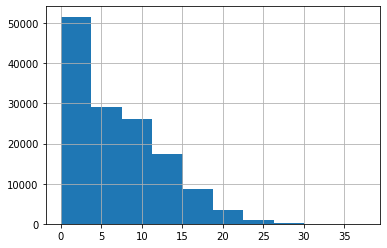

In [20]:
calls_raw['duration'].hist()
plt.show()

We see that the median `duration` value of the calls is 6 min, while the mean `duration` value is 6 min 45 seconds (the distribution seems to be left skewed), and 25% of all calls are less than 1 min and 30 seconds long, while minimum `duration` is zero. Let's look more closely at those zero-duration calls.

In [21]:
zero_num = len(calls_raw[calls_raw['duration']==0])
zer_share = zero_num/len(calls_raw)
print(f'Total number of zero-duration calls is {zero_num}; {zer_share*100:.1f}% of all calls.')

Total number of zero-duration calls is 26834; 19.5% of all calls.


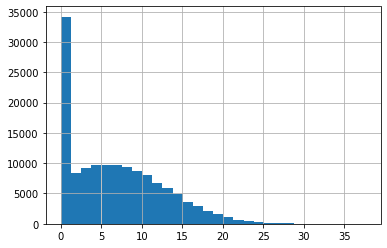

In [22]:
calls_raw['duration'].hist(bins = 30)
plt.show()

The common sense tells that it is safe to say that zero-duration calls are essentially missed calls. Let's check the statistics on all other calls.

In [23]:
non_zero_calls = calls_raw[calls_raw['duration']!=0]

In [24]:
non_zero_calls.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,110901.0,1247.511871,139.475249,1000.00,1127.00,1247.00,1365.00,1499.0
duration,110901.0,8.378196,5.354567,0.01,4.15,7.71,11.82,37.6
month,110901.0,9.319231,2.415025,1.00,8.00,10.00,11.00,12.0


In [25]:
# Check what is the percentage of the calls which actually had duration below 1 minute 17 seconds
len(non_zero_calls[non_zero_calls['duration']<1.29])/len(non_zero_calls)

0.06797053227653493

One can spot a drastic difference in the distribution of the call duration for calls with non-zero duration:

- the median `duration` value of the calls is 7 min 43 seconds, while the mean `duration` value is 8 min 45 seconds (the distribution of those of the calls which did take place, is actually right skewed!);
- the standard deviation is 5 min 21 second, instead 5 min 50 second;
- compared to the 25% of the calls in the case of the call raw data, the actual percentage of calls shorter than 1 minute and 17 seconds is 6.8% of the non-zero duration sub-sample. 

Let's plot the distribution of the `duration` variable for non-zero duration calls.

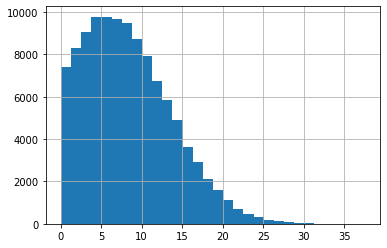

In [26]:
non_zero_calls['duration'].hist(bins = 30)
plt.show()

Now the from of the distribution makes sense.

[Back to Content](#content)

#### Internet session `duration` <a id = 'zero_int'> <a/>

Speaking of durations, let's try and perform the similar investigation into internet sessions duration.

In [27]:
internet_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,104825.0,1242.496361,142.053913,1000.0,1122.00,1236.00,1367.00,1499.00
mb_used,104825.0,366.713701,277.170542,0.0,136.08,343.98,554.61,1693.47
month,104825.0,9.342552,2.400404,1.0,8.00,10.00,11.00,12.00


First, we see that there is nothing unusual about the internet usage, maximum is 1693 Mb and it sounds totally OK; however, similarly to the call duration, we can spot zero usage here as well.

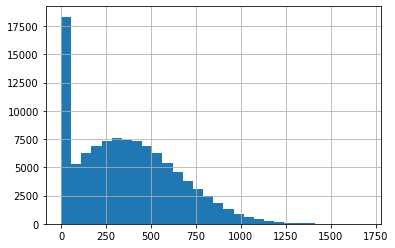

In [28]:
internet_raw['mb_used'].hist(bins = 30)
plt.show()

Hm, the form of the distribution resembles that of the call duration.

Note: one should take into account that internet traffic can be measured with higher resolution, rather than 0.01 of a Mb and it will still make sense (as opposed to the call duration, in which case it is reasonable to assume that it takes at least one second of a talk to answer the call and say a word or make a sound); thus, zero-usage sessions can be an artifact of decimals rounding; the issue can be investigated additionaly with the colleagues from the billing team.

In [29]:
zero_usage = len(internet_raw[internet_raw['mb_used']==0])
zeri_share = zero_usage/len(internet_raw)
print(f'Total number of zero-usage session is {zero_usage}; {zeri_share*100:.1f}% of all sessions.')

Total number of zero-usage session is 13747; 13.1% of all sessions.


Let's cut them off: whether these are indeed an artifact of the rounding or unsuccessful sessions, they are not contributing from the accounting point of view and do not impact the total traffic calculations.

In [30]:
non_zero_sessions = internet_raw[internet_raw['mb_used']!=0]

In [31]:
non_zero_sessions.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,91078.0,1242.576923,141.992374,1000.00,1122.00,1236.000,1367.0000,1499.00
mb_used,91078.0,422.064206,255.063501,0.01,223.38,395.905,588.3675,1693.47
month,91078.0,9.339160,2.399309,1.00,8.00,10.000,11.0000,12.00


As in the previous case, one can see a dramatic change in the distribution statistics. Let's visualize it.

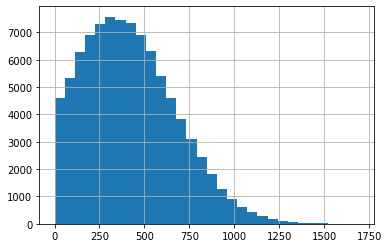

In [32]:
non_zero_sessions['mb_used'].hist(bins = 30)
plt.show()

These two distributions, the one of the non-zero call duration and the one of the non-zero traffic usage sessions, are essentialy cousins :)

[Back to Content](#content)

#### Distribution of the overall traffic over time  <a id = 'growth'> <a/>

Now, when we have cleaned the call and the internet sessions datasets from non-contributing observatoins, we will check the distributions of calls, messages and internet sessions per user over time.

1. Let's create separate time series with the daily number of users for each plan. <a id='users'> <a/>

In [33]:
# `surf` users data subset
surf_users = users_raw.query('plan == "surf"')
surf_users.head(1)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT


In [34]:
# `ultimate` users data subset
ultimate_users = users_raw.query('plan == "ultimate"')
ultimate_users.head(1)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT


In [35]:
def total_user_count(df):

    """
        total_user_count() is a function which takes a dataframe on users,
        creates a pivot dataframe on registrations and churns (time series),
        joins the two resulting time series (outer join),
        fills in nan values (there can be no registrations or no churns on some dates),
        adds a separate column with net registrations,
        and creates a cummulative sum column, indicating the total number of active users for a particular date.

        It takes one positional parameter:
        df  - dataframe

    """
    
    # creating a pivot table with dates as index
    df_regs = df.pivot_table(index=['reg_date'], values = 'user_id', aggfunc = 'count')
    
    # applying resampling to the timestamp index to get continuous time series
    df_regs = df_regs.resample('D').mean()
    
    # applying the same two steps to churns
    df_churn = df.pivot_table(index=['churn_date'], values = 'user_id', aggfunc = 'count')
    df_churn = df_churn.resample('D').mean()
    
    # joining (outer join for the case the two time series have different lenght)
    user_count = df_regs.join(df_churn, lsuffix="_left", rsuffix="_right", how = 'outer')
    
    # filling in missing values inplace
    user_count.fillna(0, inplace = True)
    
    # adding a net daily registration count column
    user_count['net_user_regs'] =  user_count['user_id_left'] - user_count['user_id_right']
    
    # adding a total daily user count column
    user_count['total_user_count'] = user_count['net_user_regs'].cumsum()
    
    return user_count

Let's see how many `surf` users we had by the end of 2018:

In [36]:
# daily count of `surf` plan users
surf_user_count = total_user_count(surf_users)
surf_user_count.tail()

,user_id_left,user_id_right,net_user_regs,total_user_count
2018-12-27,1.0,1.0,0.0,314.0
2018-12-28,0.0,0.0,0.0,314.0
2018-12-29,1.0,0.0,1.0,315.0
2018-12-30,1.0,1.0,0.0,315.0
2018-12-31,2.0,1.0,1.0,316.0


Let's repeat for the `ultimate` users:

In [37]:
# daily count of `ultimate` plan users
ultimate_user_count = total_user_count(ultimate_users)
ultimate_user_count.tail()

,user_id_left,user_id_right,net_user_regs,total_user_count
2018-12-27,0.0,0.0,0.0,150.0
2018-12-28,0.0,0.0,0.0,150.0
2018-12-29,0.0,0.0,0.0,150.0
2018-12-30,1.0,0.0,1.0,151.0
2018-12-31,0.0,1.0,-1.0,150.0


2. Let's create a summary time series dataframe, including daily count of total users, calls, messages, and internet sessions, as well as daily average of calls, messages and internet sessions per user. <a id='average_traffic'> <a/>

In [38]:
# creating a pivot table of calls with dates as index
daily_call_count = non_zero_calls.pivot_table(index=['call_date'], values = 'user_id', aggfunc = 'count')

In [39]:
# creating a pivot table of messages with dates as index
daily_message_count = messages_raw.pivot_table(index=['message_date'], values = 'user_id', aggfunc = 'count')

In [40]:
# creating a pivot table of internet sessions with dates as index
daily_session_count = non_zero_sessions.pivot_table(index=['session_date'], values = 'user_id', aggfunc = 'count')

In [41]:
# we will add up back the `surf` and the `ultimate` users to get the total number of users per day
total_count = surf_user_count['total_user_count']+ultimate_user_count['total_user_count']
total_count = total_count.to_frame()

# a summary dataframe, including daily count of total users, calls, messages, and internet sessions
total_count = total_count.join(daily_call_count)
total_count = total_count.join(daily_message_count, rsuffix="_message")
total_count = total_count.join(daily_session_count, rsuffix="_session")
total_count.columns = ['total_user_count', 'call_count', 'message_count', 'session_count']
total_count.tail()

,total_user_count,call_count,message_count,session_count
2018-12-27,464.0,891.0,701.0,710.0
2018-12-28,464.0,867.0,702.0,696.0
2018-12-29,465.0,847.0,680.0,685.0
2018-12-30,466.0,872.0,683.0,741.0
2018-12-31,466.0,869.0,699.0,723.0


In [42]:
# adding averages per user on calls, messages, and internet session
total_count['call_num_avg'] = total_count['call_count']/total_count['total_user_count']
total_count['message_num_avg'] = total_count['message_count']/total_count['total_user_count']
total_count['sesion_num_avg'] = total_count['session_count']/total_count['total_user_count']
total_count.tail()

,total_user_count,call_count,message_count,session_count,call_num_avg,message_num_avg,sesion_num_avg
2018-12-27,464.0,891.0,701.0,710.0,1.920259,1.510776,1.530172
2018-12-28,464.0,867.0,702.0,696.0,1.868534,1.512931,1.500000
2018-12-29,465.0,847.0,680.0,685.0,1.821505,1.462366,1.473118
2018-12-30,466.0,872.0,683.0,741.0,1.871245,1.465665,1.590129
2018-12-31,466.0,869.0,699.0,723.0,1.864807,1.500000,1.551502


Let's look how the traffic per user is distributed over time (remember, the traffic data starts on Jan 15). <a id = 'traffic_per_user'> <a/>

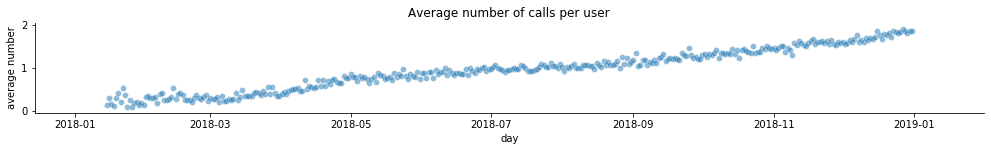

In [44]:
# for calls
ax = sns.relplot(total_count.index, total_count['call_num_avg'], height = 2, aspect = 7, alpha = 0.5)
ax.set(xlabel="day", ylabel="average number", title="Average number of calls per user")
plt.show()


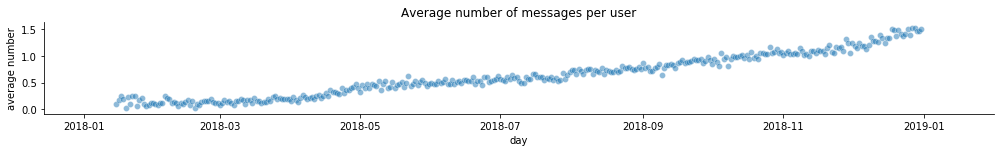

In [45]:
# for messages
ax = sns.relplot(total_count.index, total_count['message_num_avg'], height = 2, aspect = 7, alpha = 0.5)
ax.set(xlabel="day", ylabel="average number", title="Average number of messages per user")
plt.show()


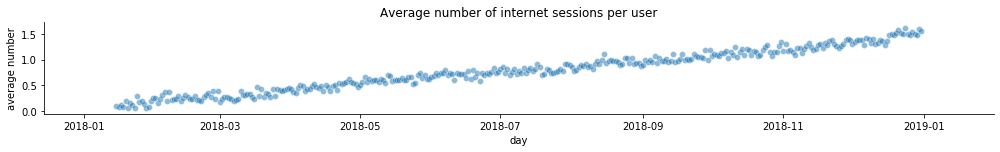

In [46]:
# for internet sessions
ax = sns.relplot(total_count.index, total_count['sesion_num_avg'], height = 2, aspect = 7, alpha = 0.5)
ax.set(xlabel="day", ylabel="average number", title="Average number of internet sessions per user")
plt.show()


The distributions look pretty strange actually, it looks like the users made about:

- 1 call in two days, and 1 message and 1 internet session in four days in the beginning of the period;
- growing steadily up to 2 calls a day, 3 messages and 3 internet sessions in two days at the end of the period...

Nothing to do about it, but it looks like something to ask experts about.

[Back to Content](#content)

### Individual user statistics <a id = 'individual_traffic'> <a/>

Lets find the following per user statistics:

- number of calls made and minutes used per month;
- number of text messages sent per month;
- volume of data per month;
- monthly revenue from each user.

First, we have to take into account the note with regard to the individual call duration rounding; to this purpose, we will add a column to the `non_zero_calls` dataframe, called `duration_min`, to round up the call duration values:

In [47]:
non_zero_calls['duration_min'] = non_zero_calls['duration'].apply(np.ceil)
non_zero_calls.head()

,id,user_id,call_date,duration,month,duration_min
0,1000_93,1000,2018-12-27,8.52,12,9.0
1,1000_145,1000,2018-12-27,13.66,12,14.0
2,1000_247,1000,2018-12-27,14.48,12,15.0
3,1000_309,1000,2018-12-28,5.76,12,6.0
4,1000_380,1000,2018-12-30,4.22,12,5.0


In [48]:
"""
Create a pivot table with user ids and months
as index to count number of calls made and minutes used per month
"""

user_calls = non_zero_calls.pivot_table(index=['user_id','month'],
                                        values = 'duration_min', aggfunc = ['count','sum'])

In [49]:
user_calls.columns = ['call_count', 'call_dur']
# user_calls

In [50]:
"""
Create a pivot table with user ids and months
as index to count number of messaged sent
"""

user_messages = messages_raw.pivot_table(index=['user_id','month'],
                                        values = 'message_date', aggfunc = ['count'])

In [51]:
user_messages.columns = ['message_count']
# user_messages

Let's add the message count to the per user call dataframe:

In [52]:
user_account = user_calls.join(user_messages, how = 'outer')
# user_account

In [53]:
"""
Create a pivot table with user ids and months
as index to count number of internet sessions made and total internet traffic per month
"""

user_internet = non_zero_sessions.pivot_table(index=['user_id','month'],
                                        values = 'mb_used', aggfunc = ['count', 'sum'])

In [54]:
user_internet.columns = ['session_count', 'total_mb']

In [55]:
#round up mb to gb usage according to the note on the internet traffic rounding up
user_internet['total_gb'] = (user_internet['total_mb']/1024).apply(np.ceil)
# user_internet

Let's add the internet traffic to `user_account` dataframe:

In [56]:
user_account = user_account.join(user_internet, how = 'outer')

In [57]:
#alternative way
#from functools import reduce 
#df_set = [user_calls, user_messages, user_internet] 
#df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['user_id','month'],
#                                          how='outer'), df_set).fillna(0).reset_index()

In [58]:
#turn the index into columns with correponsing values
user_account.reset_index(inplace = True)
# user_account

Let's add the plan for each user:

In [59]:
user_account = user_account.merge(users_raw[['user_id','plan']], on = 'user_id', how = 'left')

<a id = 'individual_traffic_results'> <a/>

In [60]:
# we can fill in the missing values with zeros, since NaN means no usage in this use case
user_account.fillna(0)

,user_id,month,call_count,call_dur,message_count,session_count,total_mb,total_gb,plan
0,1000,12,16.0,124.0,11.0,4.0,1901.47,2.0,ultimate
1,1001,8,22.0,182.0,30.0,21.0,6919.15,7.0,surf
2,1001,9,38.0,315.0,44.0,40.0,13314.82,14.0,surf
3,1001,10,47.0,393.0,53.0,48.0,22330.49,22.0,surf
4,1001,11,49.0,426.0,36.0,48.0,18504.30,19.0,surf
...,...,...,...,...,...,...,...,...,...
2288,1498,12,32.0,339.0,0.0,55.0,23137.69,23.0,surf
2289,1499,9,35.0,346.0,0.0,37.0,12984.76,13.0,surf
2290,1499,10,41.0,385.0,0.0,50.0,19492.43,20.0,surf
2291,1499,11,39.0,308.0,0.0,42.0,16813.83,17.0,surf


[Back to Content](#content)

Now, we can calculate the monthly revenue for each user. Note: to make the things a bit simplier, we have already made an assumption that individual payment periods are calendar months (it can be based on the registration date, this will add some degree of complexity to the revenue analysis). To perform the calculation, we will subtract the free package limit from the total number of calls, text messages, and data; then, multiply the result by the calling plan value; and add the monthly charge depending on the calling plan

Let's recap on the plans:

In [61]:
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Let's set `plan_name` to be the index to retrieve the plan parameter values by parameter name and plan name.

In [62]:
plans.set_index('plan_name', inplace = True)
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
plan_name,,,,,,,
surf,50,15360,500,20,10,0.03,0.03
ultimate,1000,30720,3000,70,7,0.01,0.01


Let's leave only the relevant columns:

In [63]:
account = user_account[['user_id', 'month', 'call_dur', 'message_count', 'total_gb', 'plan']]

Let's define a function, which will count the total monthly payment for each user in a subset of users of a given plan, based on the extra minutes, messages, and GBs consumed by the user.

In [64]:
def payment(user_df, plans):
    
    """
        payment() is a function which takes a dataframe on users traffic monthly stats
        for different plans and a dataframe with plan parameters and for each plan\
        in the plan dataframe filters out the relevant user traffic data,
        adds columns with extra minutes, extra messages,and extra internet traffic,
        and finally, adds a column with total payment.

        It takes two positional parameters:
        
        user_df  - the data on users traffic monthly stats, which should include
                    ['user_id', 'month', 'call_dur', 'message_count',
                    'total_gb', 'plan'] columns;
        
        plans - a dataframe with plan discriptions; should include ['messages_included',
        'mb_per_month_included', 'minutes_included', 'usd_monthly_pay', 'usd_per_gb',
        'usd_per_message', 'usd_per_minute'] parameters of payment plans with `plan_names`
        as index.

    """
    # define a dictionary to add the resulting payment dataframe for each plans
    plan_stat_dict = {}
    
    for plan_name in plans.index:
   
        # define the dictionary of the plan paramaters:
        param = plans.T[plan_name].to_dict()
        # filter user data for the `plan` plan
        df = user_df.query('plan == @plan_name')

        # calculating extra minutes and their cost
        t = param['minutes_included']
        p = param['usd_per_minute']
        df['usd_extra_min'] = (p*(df['call_dur'] - t)).where(df['call_dur'] > t, 0)

        # calculating extra messages and their cost
        t = param['messages_included']
        p = param['usd_per_message']
        df['usd_extra_messages'] = (p*(df['message_count'] - t)).where(df['message_count'] > t, 0)

        # calculating extra Gb and their cost    
        t = param['mb_per_month_included']/1024
        p = param['usd_per_gb']
        df['usd_extra_gb'] = (p*(df['total_gb'] - t)).where(df['total_gb'] > t, 0)

        # calculating extra payment in addition to the regular payment
        df['total_payment'] = (df['usd_extra_min'] + 
                                        df['usd_extra_messages'] + 
                                          df['usd_extra_gb'] + param['usd_monthly_pay'])

        plan_stat_dict[plan_name] = df
    
    return plan_stat_dict

In [65]:
# for the two plan_names in `plans` dataframe
plan_stat_dict = payment(account, plans)
    

Finally, we have two datasets, for each payment plan, containing monthly data on mobile services usage und billing for each user. <a id = 'individual_payment'> <a/>

In [66]:
plan_stat_dict['surf'].head()

,user_id,month,call_dur,message_count,total_gb,plan,usd_extra_min,usd_extra_messages,usd_extra_gb,total_payment
1,1001,8,182.0,30.0,7.0,surf,0.0,0.00,0.0,20.00
2,1001,9,315.0,44.0,14.0,surf,0.0,0.00,0.0,20.00
3,1001,10,393.0,53.0,22.0,surf,0.0,0.09,70.0,90.09
4,1001,11,426.0,36.0,19.0,surf,0.0,0.00,40.0,60.00
5,1001,12,412.0,44.0,19.0,surf,0.0,0.00,40.0,60.00


In [67]:
plan_stat_dict['ultimate'].head()

,user_id,month,call_dur,message_count,total_gb,plan,usd_extra_min,usd_extra_messages,usd_extra_gb,total_payment
0,1000,12,124.0,11.0,2.0,ultimate,0.0,0.0,0.0,70.0
19,1006,11,10.0,15.0,3.0,ultimate,0.0,0.0,0.0,70.0
20,1006,12,59.0,139.0,32.0,ultimate,0.0,0.0,14.0,84.0
26,1008,10,476.0,21.0,17.0,ultimate,0.0,0.0,0.0,70.0
27,1008,11,446.0,37.0,24.0,ultimate,0.0,0.0,0.0,70.0


[Back to Content](#content)

### Conclusions and further steps

To sum up the data preprocessing step:
1. We converted the date columns into the date type and, to each traffic-related dataframe, added a `month` column.
2. We have spotted zero duration calls, which comprised 19.4% of the initial dataset on calls and which essentially mean missed calls; we have dropped them to reveal the actual distribution of the call duration.
3. We have spotted zero usage internet sessions, which comprised 13.1% of the initial dataset on internet sessions and which essentially can mean either rounding up artifact or unsuccessful connections; we have dropped them to reveal the actual distribution of the internet traffic usage.
4. For the user sample at hand, we explored the daily growth of the "user base" for the two payment plans of interest and revealed upward trends in the overall mobile services consumption for each type of service (calls, messages, internet); the trends looked unexpectedly strange in the absolute numbers.
5. Finally, we explored monthly mobile service consumption and the total cost on the user level: we found the number of calls made and minutes used per month, the number of text messages sent per month, the volume of data consumed per month, and the monthly revenue from each user, including the extra costs incurred for the extra traffic, besides the volumes included in the plans.

Further steps:
1. Perform exploratory data analysis, including calculating basic stats and plotting histograms for the minutes, texts, and volume of data the users of each plan acquired per month.
2. Perform statistical data analysis, namely test hypotheses of different revenue from users of `Surf` and `Ultimate` calling plans.
3. Sum up findings and write conclusions.

[Back to Content](#content)

## EDA <a id='eda'> <a/>

Let's define explicitly the two datasets of monthly usage data for users of the two plans:

In [68]:
surf_stats = plan_stat_dict['surf']
ultimate_stats = plan_stat_dict['ultimate']

Let's take a look at "head on" stats when aggregated numbers are calculated across the users and months.

In [69]:
surf_stats.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,1573.0,1242.755245,139.227939,1001.0,1120.0,1245.00,1358.00,1499.00
month,1573.0,9.182454,2.468199,1.0,8.0,10.00,11.00,12.00
call_dur,1544.0,436.802461,229.088544,2.0,279.0,430.00,579.00,1510.00
message_count,1222.0,40.109656,33.035500,1.0,16.0,32.00,54.00,266.00
total_gb,1558.0,16.831194,7.711922,1.0,12.0,17.00,21.00,70.00
usd_extra_min,1573.0,1.843770,3.765744,0.0,0.0,0.00,2.28,30.30
usd_extra_messages,1573.0,0.210381,0.584127,0.0,0.0,0.00,0.00,6.48
usd_extra_gb,1573.0,38.652257,54.456269,0.0,0.0,20.00,60.00,550.00
total_payment,1573.0,60.706408,55.388042,20.0,20.0,40.36,80.36,590.37


In [70]:
ultimate_stats.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,720.0,1253.330556,150.915644,1000.0,1126.0,1241.5,1401.0,1497.0
month,720.0,9.151389,2.558495,1.0,8.0,10.0,11.0,12.0
call_dur,712.0,435.286517,237.459650,10.0,263.0,425.5,566.0,1369.0
message_count,584.0,46.296233,32.942118,1.0,21.0,41.0,66.0,166.0
total_gb,719.0,17.331015,7.648185,1.0,13.0,17.0,21.0,46.0
usd_extra_min,720.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
usd_extra_messages,720.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
usd_extra_gb,720.0,2.313889,11.395108,0.0,0.0,0.0,0.0,112.0
total_payment,720.0,72.313889,11.395108,70.0,70.0,70.0,70.0,182.0


The following observations can be derived from the above statistics:

1. The monthly user statistics dataframe includes approximately two times more data points for the `surf` plan than for the `ultimate` plan.
2. The users of the both plans have essentially the same average monthly call duration of 435 minutes, which is below the `surf` limit of 500 minutes.
3. The users of the both plans have similar average monthly number of messages, with `ultimate` users having only 6 messages more on average than `surf` users, while both means do not exceed the `surf` limit of 50 messages.
4. The similar picture can be observed with regard to the internet traffic: both the `surf` users and the `ultimate` users use appr. 17 Gb of the internet traffic per month on average.
5. Thus, while there are minor extra costs inquired for the extra minutes and messages for some users of the `surf` plan compared to the `ultimate` users, who do not have extra payments on calls and messages at all, they experience what seems to be significantly higher extra cost of the internet traffic: the `surf` users are billed USD 38.65 extra payment per month for it compared to USD 2.32 for the `ultimate` users.
6. Nevertheless, due to the USD 50 difference in the price of the plans (the `surf` plan costs only USD 20, while the `ultimate` plan costs USD 70), on average  the `surf` users still pay less than the `ultimate` users, and when the medians are compared, 50% of the `surf` users pay USD 40 and less, while, naturally, the `ultimate` users always pay at least USD 70.
7. The lower limit and the costly extra payment for the internet traffic for the `surf` users results in much higher dispersion of the final bills, the estimated standard deviation for the `total_payment` is 5 times higher for the `surf` users than for the `ultimate` users.

Actually, we remember the strange upward trends in the consumption of all three mobile services, which means we cannot build upon the "head on" stats only and should check out the monthly averages/medians. 

Let's define the list of variables for pivoting by months:

In [71]:
values = ['call_dur', 'message_count',
          'total_gb', 'usd_extra_min', 'usd_extra_messages', 'usd_extra_gb', 'total_payment']

Let's check how many users there were in every month and plan. <a id = 'monthly_user_count'> <a/>

In [72]:
surf_users_monthly = surf_stats.pivot_table(index=['month'], values = 'user_id', aggfunc = 'count')
surf_users_monthly.T

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,2,9,23,50,77,97,121,162,194,237,283,318


In [73]:
ultimate_users_monthly = ultimate_stats.pivot_table(index=['month'], values = 'user_id', aggfunc = 'count')
ultimate_users_monthly.T

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,4,7,12,21,29,47,59,71,86,106,127,151


**Looks like we have too few users in the beginning of the year and there is no sense to calculate and compare aggregated stats at least for the first threee months, maybe even four months. We have to drop the observations from January to March.**

In [74]:
surf_stats = surf_stats.query('month > 3')
ultimate_stats = ultimate_stats.query('month > 3')

[Back to Content](#content)

Let's check monthly statistics, separately for each plan, both the means and the medians.

In [75]:
# creating a pivot on months for `surf` users, aggfunc - default mean
surf_stats_monthly = surf_stats.pivot_table(index=['month'], values = values)

Note: we use `apply(np.ceil)` method to make getting through the numbers easier.

In [76]:
surf_stats_monthly.T.apply(np.ceil)

month,4,5,6,7,8,9,10,11,12
call_dur,352.0,411.0,436.0,454.0,418.0,421.0,441.0,433.0,485.0
message_count,25.0,34.0,34.0,36.0,38.0,40.0,43.0,41.0,49.0
total_gb,13.0,15.0,16.0,18.0,18.0,17.0,18.0,17.0,19.0
total_payment,41.0,48.0,50.0,63.0,64.0,59.0,66.0,59.0,71.0
usd_extra_gb,20.0,26.0,28.0,41.0,43.0,37.0,44.0,37.0,48.0
usd_extra_messages,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
usd_extra_min,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,3.0


In [77]:
# creating a pivot on months for `surf` users, aggfunc - median
surf_stats_monthly = surf_stats.pivot_table(index=['month'], values = values, aggfunc = 'median')

In [78]:
surf_stats_monthly.T.apply(np.ceil)

month,4,5,6,7,8,9,10,11,12
call_dur,340.0,429.0,432.0,459.0,395.0,429.0,437.0,419.0,453.0
message_count,19.0,26.0,27.0,30.0,31.0,31.0,35.0,33.0,38.0
total_gb,12.0,14.0,16.0,17.0,17.0,17.0,18.0,17.0,18.0
total_payment,20.0,22.0,31.0,41.0,42.0,41.0,50.0,40.0,50.0
usd_extra_gb,0.0,0.0,10.0,20.0,20.0,20.0,30.0,20.0,30.0
usd_extra_messages,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
usd_extra_min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
# creating a pivot on months for `ultimate` users, aggfunc - default mean
ultimate_stats_monthly = ultimate_stats.pivot_table(index=['month'], values = values)

In [80]:
ultimate_stats_monthly.T.apply(np.ceil)

month,4,5,6,7,8,9,10,11,12
call_dur,337.0,407.0,388.0,428.0,422.0,438.0,456.0,453.0,466.0
message_count,29.0,45.0,37.0,42.0,48.0,46.0,47.0,48.0,54.0
total_gb,17.0,17.0,16.0,17.0,18.0,18.0,18.0,18.0,19.0
total_payment,73.0,71.0,72.0,72.0,73.0,73.0,73.0,72.0,74.0
usd_extra_gb,3.0,1.0,2.0,2.0,3.0,3.0,3.0,2.0,4.0
usd_extra_messages,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
usd_extra_min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
# creating a pivot on months for `ultimate` users, aggfunc - median
ultimate_stats_monthly = ultimate_stats.pivot_table(index=['month'], values = values, aggfunc = 'median')

In [82]:
ultimate_stats_monthly.T.apply(np.ceil)

month,4,5,6,7,8,9,10,11,12
call_dur,301.0,407.0,400.0,430.0,406.0,434.0,461.0,433.0,445.0
message_count,21.0,35.0,31.0,35.0,42.0,47.0,40.0,41.0,49.0
total_gb,16.0,17.0,15.0,15.0,18.0,17.0,17.0,17.0,17.0
total_payment,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0
usd_extra_gb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
usd_extra_messages,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
usd_extra_min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**The following additional observation can be derived from the monthly means and medians: while the `ultimate` users monthly bill had been kept around USD72-73, the `surf` users had experienced a steep growth in the monthly payments: by the end of 2018, they were billed as much as the `ultimate` users, which was due to the growth in the extra payment for the mobile internet traffic:** <a id = 'extra_gb'> <a/>

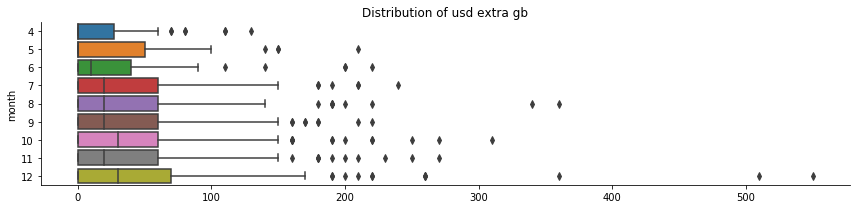

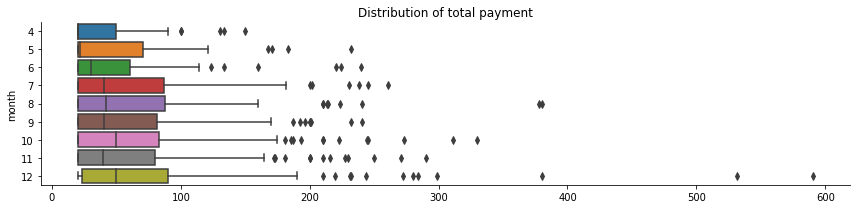

In [83]:
# plot monthly box plots for the `surf` users
for var in values[5:7]:

    sns.catplot(x=var, y='month', data=surf_stats, kind = 'box', height=3, aspect=4, orient = "h")
    plt.xlabel("")
    plt.title("Distribution of {}".format(' '.join(var.split('_'))), y=1)

plt.show()

[Back to Content](#content)

Let's illustrate the upward trend in the overall mobile services usage for the two plans as well (note: the distributions are mainly symmetrical, with the monthly message count a bit right skewed for the `surf` users and the monthly call duration a bit left skewed for the `ultimate` users). <a id = 'trend_viz'> <a/>

In [84]:
# reset month as an index for the plotting needs
surf_stats_monthly.reset_index(inplace = True)
ultimate_stats_monthly.reset_index(inplace = True)

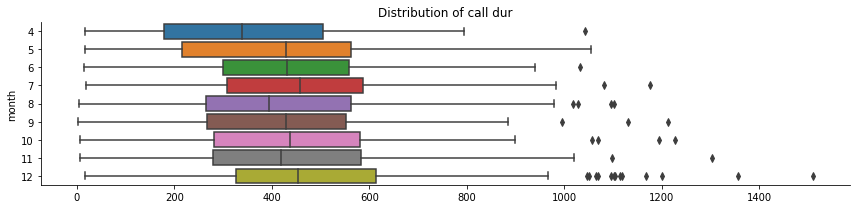

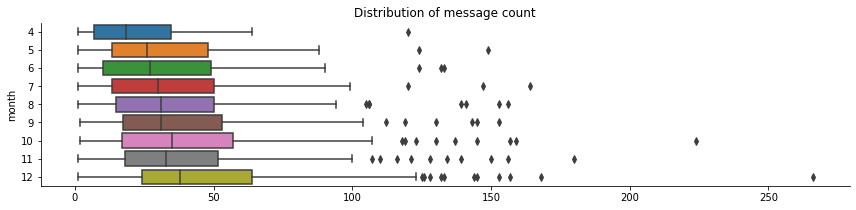

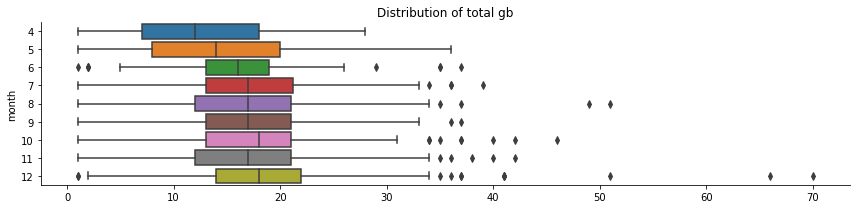

In [85]:
# plot monthly box plots for the `surf` users
for var in values[:3]:

    sns.catplot(x=var, y='month', data=surf_stats, kind = 'box', height=3, aspect=4, orient = "h")
    plt.xlabel("")
    plt.title("Distribution of {}".format(' '.join(var.split('_'))), y=1)

plt.show()

For the `ultimate` users, the upward trend holds only with regard to the total monthly call duration and monthly message count (in any case, only outliers pay for additional minutes and gigabytes): 

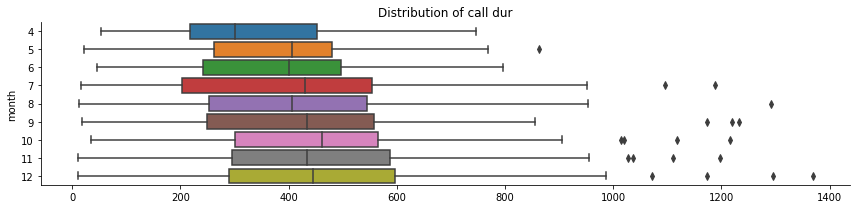

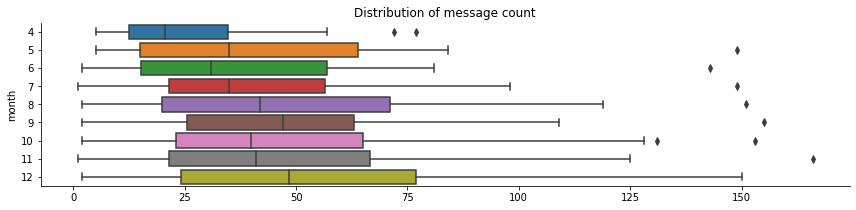

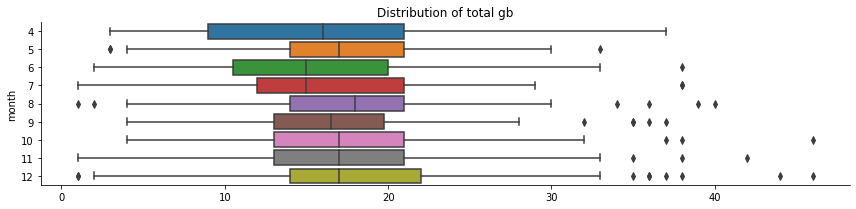

In [86]:
# plot monthly box plots for the `ultimate` users
for var in values[:3]:

    sns.catplot(x=var, y='month', data=ultimate_stats, kind = 'box', height=3, aspect=4, orient = "h")
    plt.xlabel("")
    plt.title("Distribution of {}".format(' '.join(var.split('_'))), y=1)

plt.show()

[Back to Content](#content)

### Conclusions and further steps

In what follows, the findings are summirized for the exploratory analysis.

1. The user sample includes approximately two times more users of the `surf` plan than the `ultimate` plan.
2. The users of the both plans mostly use less than 500 minutes of calls per month.
3. The users of the both plans mostly send less than 50 messages, with `ultimate` users sending slightly more.
4. Both the `surf` users and the `ultimate` users use 17-18 Gb of the internet traffic per month on average, which results in significantly higher extra cost of the internet traffic for the `surf` users: on average they were billed appr. USD 40 of extra payments per month.
5. Despite the fact that on average  the `surf` users still paid less than the `ultimate` users, the `surf` users had experienced a steep growth in the monthly payments: by the end of 2018, their bill had become equal to that of the `ultimate` users, which was due to the growth in the extra payment for the mobile internet traffic.

In addition, there were too few users in the beginning of 2018 in the data sample; thus, we had to drop the first three months of mobile traffic observations to look at the monthly stats.

At the next step, we should conduct statistical data analysis; we will test the hypothesis that the average revenue from users of `ultimate` and `surf` calling plans differs.

[Back to Content](#content)

## SDA <a id='sda'> <a/>

In what follows we employ numerical methods of hypothesis testing to conduct statistical significance checks for selected sample means. To this end, we employ the two-sample t-test is used to determine if two population means are equal. The Python implementation of the t-test is [`scipy.stats.ttest_ind()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) function. Before applying it, we will check whether the two samples have equal variances. 

Before running the t-test, we will employ either [Bartlett’s test](https://www.itl.nist.gov/div898/handbook/eda/section3/eda357.htm) or [the Levene test](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35a.htm) for equal variances. The Bartlett test tests the null hypothesis that all input samples are from populations with equal variances for normal populations; the Python implementation of this test is [`scipy.stats.bartlett()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bartlett.html#scipy.stats.bartlett) function. Levene’s test has better performance in cases with significant deviations from normality; The Python implementation of this test is [`scipy.stats.levene()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html) function. Let's check what assumption is more reasonable in case of revenue variable `total_payment`. To this end, we will first run the scatter matrix and compare the two subsets, of `surf` users and `ultimate` users.

In [87]:
# append the two datasets
user_stats = surf_stats.append(ultimate_stats)

We will filter columns to get more readable scatter matrix: we do not need "distribution" of `user_id`'s and we know how the user base had been growing during the period under consideration.

In [88]:
col = user_stats.columns.to_list()
col.remove('user_id')
col.remove('month')

Let's run the scatter matrix for the whole period first. To make it visually simplier, we will plot only one corner of it. <a id = 'normality'> <a/>

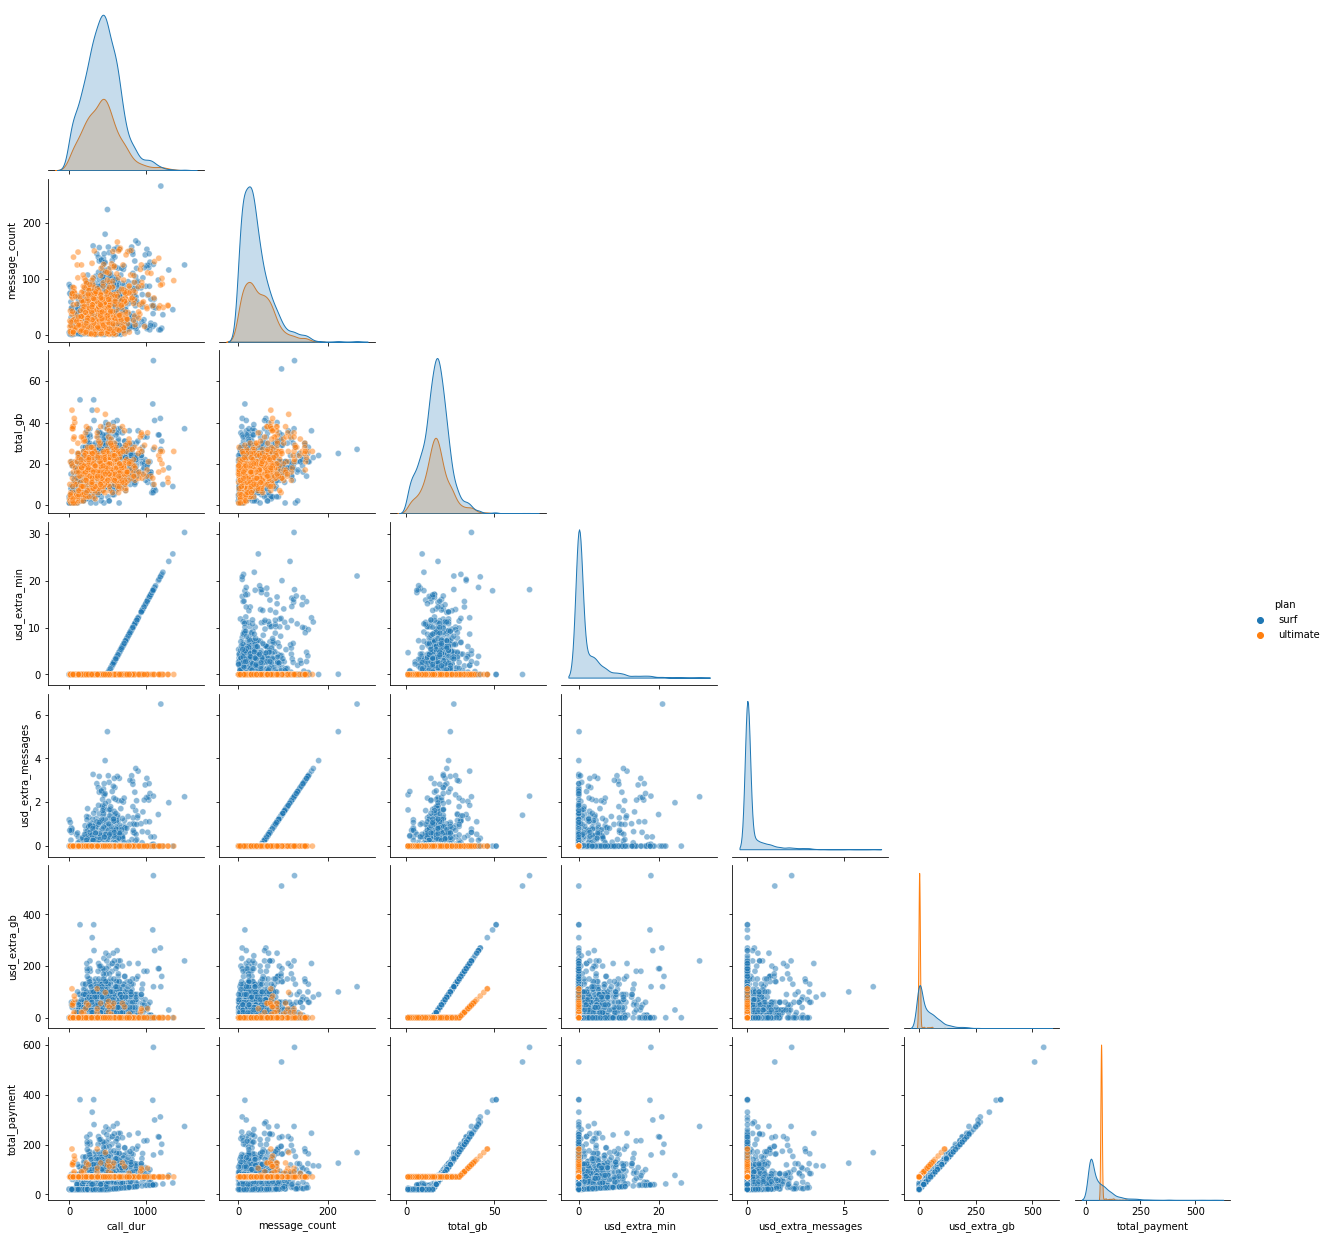

In [89]:
# run seaborn pairplot with KDE functions in diagonal and diffirentiating the subsets by means of the `hue` parameter
axs = sns.pairplot(user_stats[col], diag_kind = 'kde', hue = 'plan', plot_kws = {'alpha': 0.5}, corner = True)
sns.set(font_scale=1.5)
plt.show()

From the previous analysis we know that the number of user was steadily growing from month to month with the highest number of users registered in the month of December 2018; thus, to get more robust estimation of the probability density function form of the relevant variables, we will run the same scatter matrix for this month only.

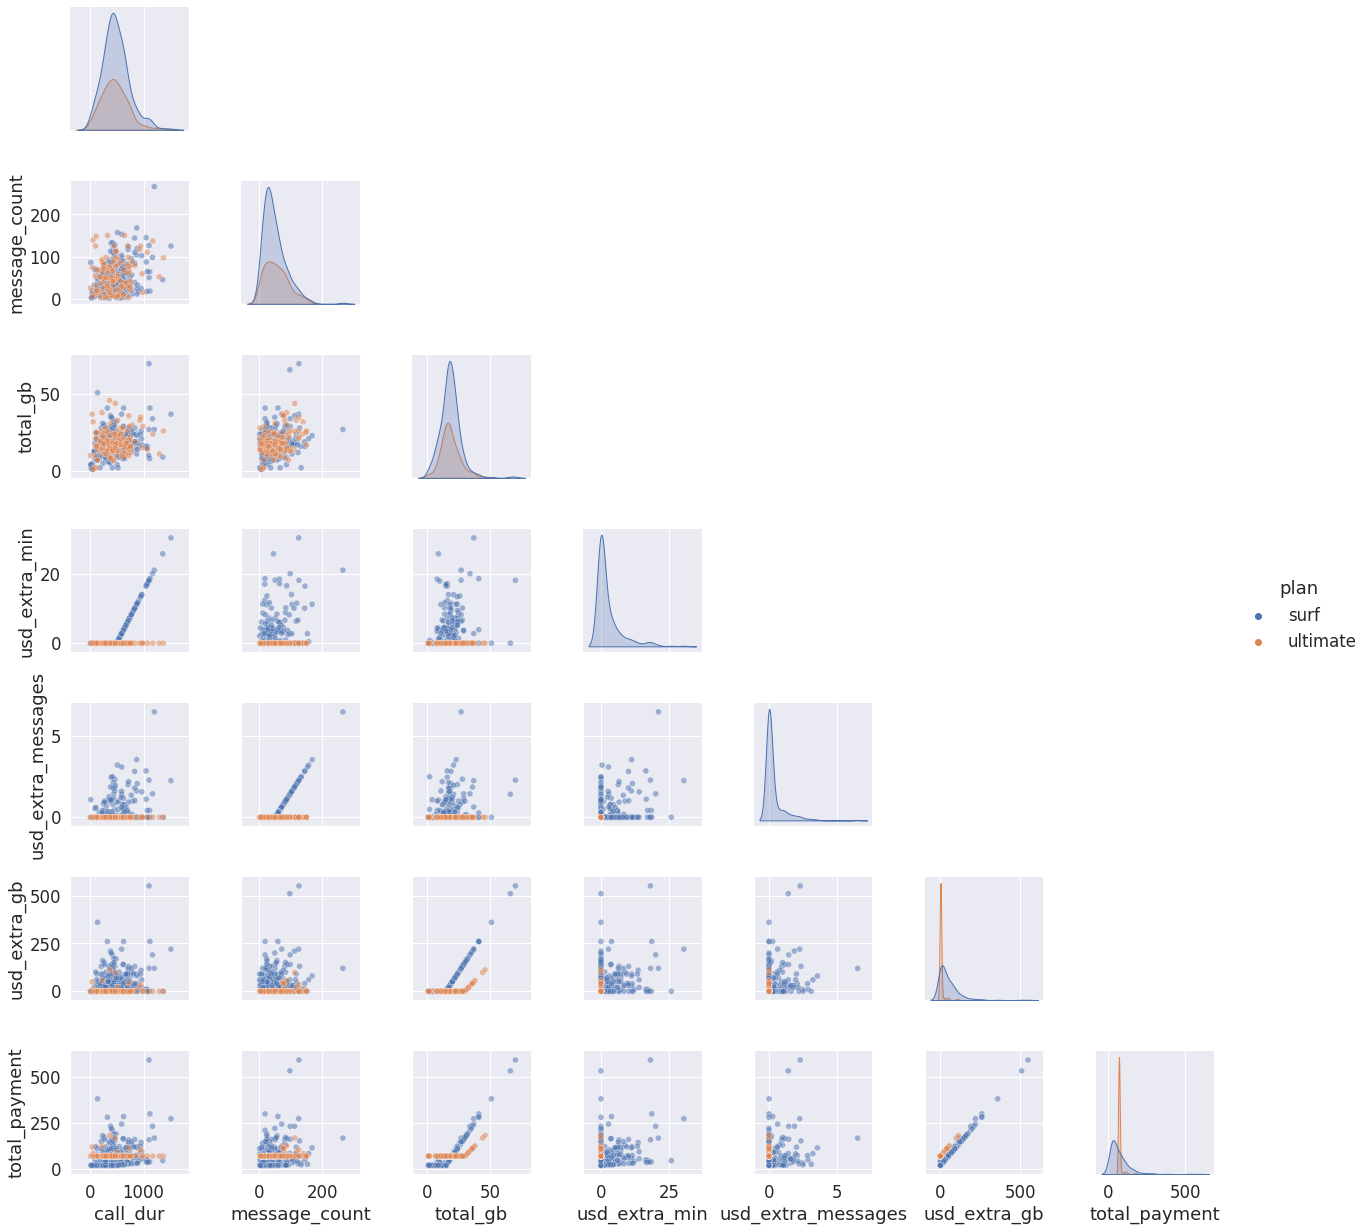

In [90]:
axs = sns.pairplot(user_stats[user_stats['month']==12][col], diag_kind = 'kde', hue = 'plan', plot_kws = {'alpha': 0.5}, corner = True)
sns.set(font_scale=1.5)
plt.show()

According to the probability density function estimate for the `total_payment` variable, one can note that we have no reason to assume that the distibutions are normal; moreover, they seem to have diferent variances. We will double check the latter observation by running the Levene test. <a id = 'normality_rejected'> <a/>

[Back to Content](#content)

### Testing the difference in average revenues from `surf` and `ultimate` users <a id = 'test1'> <a/>

#### Levene test

1. Null-hypothesis: `surf` and `ultimate` samples have equal variance for `total_payment` distribution;
2. p-value: 5%;
3. The alternative hypothsis is that `surf` and `ultimate` samples have different variance for `total_payment` distribution. If the p-value is smaller than 5%, then we will have evidence against the null hypothesis of equal variance, so that we will have to define the `equal_var` attribute of the t-test as `False` and perform [Welch's variation of the t-test](https://en.wikipedia.org/wiki/Welch%27s_t-test).

In [91]:
stat, p = stats.levene(surf_stats['total_payment'], ultimate_stats['total_payment'])
p

5.036989744065254e-81

The p-value is essentially zero, so a conclusion can be made that the two samples under consideration have different variances and Welch's t-test should be used to test for equal means.

#### t-test

1. Null hypothesis:  `surf` and `ultimate` samples have equal `total_payment` means;
2. p-value: 5%;
3. We will use the default two-sided version, i.e. the alternative hypothesis is that surf and ultimate samples have different `total_payment` means; if the p-value is smaller than 5%, we will have evidence against the null hypothesis of equal population means.

In [92]:
stat, p = stats.ttest_ind(surf_stats['total_payment'], ultimate_stats['total_payment'], equal_var=False)
p

8.145922869289353e-14

The null-hypothesis is rejected; two samples have different means, i.e. `surf` users and `ultimate` users, on average, bring different revenue.

[Back to Content](#content)

### Testing the difference in average revenues from `surf` and `ultimate` users for Dececmber 2018  <a id = 'test2'> <a/>

We remember, that the average payment of the `surf` users seemed to be similar to that of the `ultimate` users in December 2018. Let's test separetely, the hypothesis that the average revenue from users of ultimate and surf calling plans differs in December 2018. To this end, we will perform the same steps, but filter the data on the `month` variable, which value we will set to be 12.

In [93]:
stat, p = stats.levene(surf_stats[surf_stats['month']==12]['total_payment'],
                         ultimate_stats[ultimate_stats['month']==12]['total_payment'])
p

2.4675162548118005e-15

The two samples under consideration still have unequal variances.

In [94]:
stat, p = stats.ttest_ind(surf_stats[surf_stats['month']==12]['total_payment'],
                         ultimate_stats[ultimate_stats['month']==12]['total_payment'], equal_var=False)
p

0.4931560010824242

As to the average revenue from a user, the p-value of the t-test is essentially 0.5 and in any case we cannot reject the null hypothesis that the average revenues per user were equal for two plans.

[Back to Content](#content)

### Testing the difference in average revenues from users in the MSA with the most users versus other MSAs  <a id = 'test3'> <a/>

Let's check which MSA the most users are from:

In [95]:
users_raw['city'].value_counts().head(1)

New York-Newark-Jersey City, NY-NJ-PA MSA    80
Name: city, dtype: int64

80 out of 500 users in the sample are from `New York-Newark-Jersey City, NY-NJ-PA MSA`. Let's test separetely, the hypothesis that the average revenue from users in `New York-Newark-Jersey City, NY-NJ-PA MSA` differs from that of other MSAs. To this end, we will perform the same steps, but filter the data on the `city` variable, which value we will set to be `New York-Newark-Jersey City, NY-NJ-PA MSA`, for which, in turn, we will merge plan stats dataframes with the data on `city` variable from `users_raw` dataframe.

Let's merge the `user_stats` dataframe with `city` variable:

In [96]:
user_stats = user_stats.merge(users_raw[['user_id','city']], on = 'user_id', how = 'left')

In [97]:
# to make it more convenient we will store the NY-NJ-PA MSA in the `c` variable
c = "New York-Newark-Jersey City, NY-NJ-PA MSA"

Let's run the Levene test for the both of the plans:

In [98]:
stat, p = stats.levene(user_stats[user_stats['city']==c]['total_payment'],
                         user_stats[user_stats['city']!=c]['total_payment'])
p

0.14035230189275621

Levene test for the `surf` users only:

In [99]:
stat, p = stats.levene(user_stats[(user_stats['city']==c) & (user_stats['plan']=='surf')]['total_payment'],
                         user_stats[(user_stats['city']!=c) & (user_stats['plan']=='surf')]['total_payment'])
p

0.12389170741969377

Levene test for the `ultimate` users only:

In [100]:
stat, p = stats.levene(user_stats[(user_stats['city']==c) & (user_stats['plan']=='ultimate')]['total_payment'],
                         user_stats[(user_stats['city']!=c) & (user_stats['plan']=='ultimate')]['total_payment'])
p

0.050998043570857736

The null-hypothesis of equal variances should be rejected in all cases, though the case of `ultimate` users can be seen as ambiguous; thus, we cannot assume that the variances of the two distributions, for the residents of NY-NJ-PA MSA and for residents of other MSA's, are different.

Let's run the Welch t-test for both plans:

In [101]:
# equal variances
stat, p = stats.ttest_ind(user_stats[user_stats['city']==c]['total_payment'],
                         user_stats[user_stats['city']!=c]['total_payment'])
p

0.05351340280123314

The p-value is higher that 0.05, i.e. we do not have enough evidence to reject the null hypotheses at the 5% confidence level; thus, we will conclude that the average revenue from users in `NY-NJ-PA MSA` does not differ from that of the users from other MSAs. <a id='test3_accepted'> <a/>

The Welch t-test for `surf` users:

In [102]:
# equal variances, `surf` subset
stat, p = stats.ttest_ind(user_stats[(user_stats['city']==c) & (user_stats['plan']=='surf')]['total_payment'],
                         user_stats[(user_stats['city']!=c) & (user_stats['plan']=='surf')]['total_payment'])
p

0.16671668192841285

The Welch t-test for `ultimate` users:

In [103]:
# equal variances, `ultimate` subset
stat, p = stats.ttest_ind(user_stats[(user_stats['city']==c) & (user_stats['plan']=='ultimate')]['total_payment'],
                         user_stats[(user_stats['city']!=c) & (user_stats['plan']=='ultimate')]['total_payment'])
p

0.0509980435708586

The p-value is much higher that 0.05 for `surf` users and 0.51 for `ultimate` users, i.e. we do not have enough evidence to reject the null hypotheses at the 5% confidence level; thus, we will conclude that the average revenue from users in NY-NJ-PA MSA, for each payment plan, does not differ from that of the users from other MSAs. 

[Back to Content](#content)

### Hypothesis testing summary

We have tested three hypotheses of different character:
1. `surf` and `ultimate` samples have equal `total_payment` means;
2. `surf` and `ultimate` samples have equal `total_payment` means for December 2018;
3. `NY-NJ-PA MSA` sample of users has `total_payment` mean equal to that of the users from the rest of MSAs, for each of the payment plans.

With regard to the difference between two payment plans, the first hypothesis was rejected; on the other hand, the second hypothesis could not be rejected. Given that the `surf` users had been steadily using more internet traffic, the conclusion would be that the two plans generate the same average revenue when users consume 19 GB of the internet traffic and, obviously, the `surf` plan generates even more revenue if the user acquires more internet traffic:

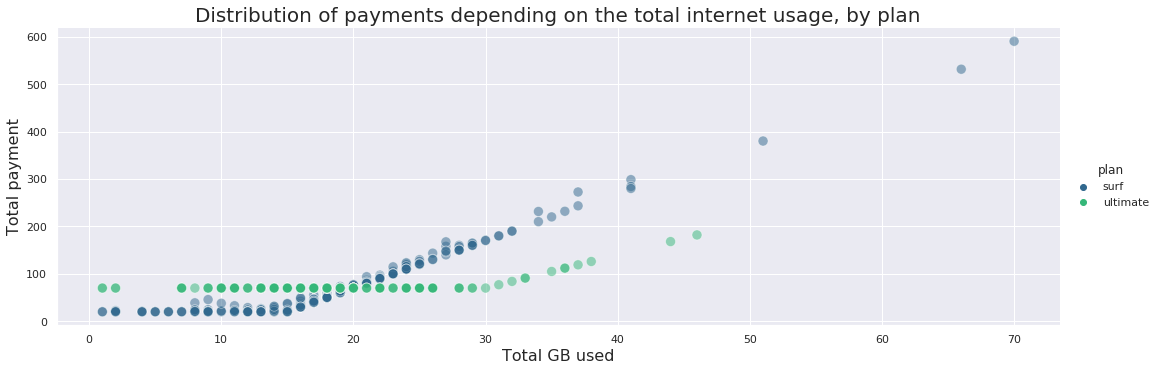

In [104]:
# illustrate the 19 Gb revenue equality point
sns.set(rc={"figure.figsize":(12, 8)})

axs = sns.relplot(y = 'total_payment', x = 'total_gb', palette="viridis",
                    data = user_stats[user_stats['month']==12], hue = 'plan', aspect = 3, s = 100, alpha = 0.5)

plt.xlabel("Total GB used", fontsize = 16)
plt.ylabel("Total payment", fontsize = 16)
plt.title("Distribution of payments depending on the total internet usage, by plan", y = 0.85, fontsize = 20)



plt.show()


With regard to the `NY-NJ-PA MSA`, there is not enough evidence that the revenue per user in this MSA was different from that in other MSAs.

Note: in each case we tested the hypothesis of equal variance (which was rejected), to correctly choose the t-test option.

An additional note should be mentioned: one should remeber that there are much more `surf` users than `ultimate` users; thus, as a product the `surf` payment plan is more profitable than the `ultimate` payment plan, as illustrated below: <a id = 'last_note'> <a/>

In [105]:
plan_stats_monthly = user_stats.pivot_table(index=['month', 'plan'], values = ['user_id', 'total_payment'], aggfunc = {'user_id': 'count', 'total_payment': 'sum'}).reset_index()
plan_stats_monthly.columns = ['month', 'plan', 'total_revenue', 'user_count' ]

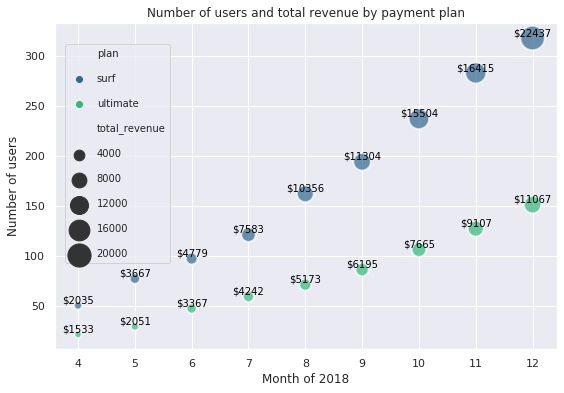

In [106]:
#set figure size
sns.set(rc={"figure.figsize":(9, 6)})

#create the scastterplot
sns.scatterplot(y = 'user_count', x = 'month', size = 'total_revenue',
                hue = 'plan', alpha = 0.7, data = plan_stats_monthly, sizes=(50, 600),
                palette="viridis", linewidth=2)

# Add titles (main and on axis)
plt.xlabel("Month of 2018")
plt.ylabel("Number of users")
plt.title("Number of users and total revenue by payment plan")

# Locate the legend inside of the plot
plt.legend(bbox_to_anchor=(0.01, 0.95), loc='upper left', fontsize=10, labelspacing=1.5)

# Annotate bubbles with bubble size
for line in range(0,plan_stats_monthly.shape[0]):
    plt.text(plan_stats_monthly.month.iloc[line],
            plan_stats_monthly.user_count.iloc[line],
            '$'+str(int(plan_stats_monthly.total_revenue.iloc[line])),
            horizontalalignment='center', verticalalignment = 'bottom', size='medium', color='black', fontsize = 10)
plt.show()

[Back to Content](#content)

## General conclusion <a id="conclusions"> <a/>

I stepped into a role of an analyst for a telecom operator called Megaline. The commercial department wanted to know which of the plans brought in more revenue, in order to adjust the advertising budget.

Initital [data overview](#explore) showed, that:
1. At our disposal was data on 137735 calls, 76051 messages, and 104825 internet sessions for 500 unique users in 73 MSAs.
2. The traffic dataset span over 50 weeks, namely 351 day from Jan 15, 2018 to Dec 31, 2018.
3. The traffic data covered the users who registered starting from Jan 01, 2018.
4. Some of the users started churning as early as on Jul 31, 2018.
5. No issues were found about the data, except for missing values in `churn_date` variable; [according to the note above](#dataset) this fact meant that the calling plan was being used at the moment the data was retrieved; from that we have learned that 6.8% of the users in the sample stopped using the corresponding plan.

At the [data preprocessing step](#preprocessing), we:

1. We converted the [date columns](#dp_type) into the date type and added a `month` column to each one of the traffic-related dataframe.
2. We have spotted [zero duration calls](#zero_dur), which comprised 19.4% of the initial dataset on calls and which essentially mean missed calls; we have dropped them to reveal the actual distribution of the call duration.
3. We have spotted [zero usage internet sessions](#zero_int), which comprised 13.1% of the initial dataset on internet sessions and which essentially can mean either rounding up artifact or unsuccessful connections; we have dropped them to reveal the actual distribution of the internet traffic usage.
4. For the user sample at hand, we explored the daily [growth of the "user base"](#users) for the two payment plans of interest (by the end of 2018, there wre 316 active `surf` users and 150 active `ultimate` users in the sample) and [revealed upward trends](#average_traffic) in the overall mobile services consumption for each type of service (calls, messages, internet); the [trends looked unexpectedly](#traffic_per_user) (we have added [plan-wise viz on them](#trend_viz) during the EDA stage).
5. Finally, we explored [individual monthly mobile service consumption](#individual_traffic) and the total cost of it for the users: we explored the [behavior](#individual_traffic_results), i.e. the number of calls made and minutes used per month, the number of text messages sent per month, the volume of data consumed per month, and calculated the [monthly revenue from each user](#individual_payment), including the extra costs incurred for the extra traffic, besides the volumes included in the plans.


The [exploratory data analysis](#eda) showed, that:

1. Overall, the users of the both plans mostly used less than 500 minutes of calls per month and sent less than 50 messages, with `ultimate` users sending appr. 6 messages more each month.
2. Both the `surf` users and the `ultimate` users used 17-18 Gb of the internet traffic per month on average, which resulted in significantly higher (as compared to the monthly basic price) extra cost of the internet traffic for the `surf` users: on average they were billed appr. USD 40 of extra payments per month.
3. There were [too few users](#monthly_user_count) in the beginning of 2018 in the data sample; thus, we had to drop the first three months of mobile traffic observations to get more robust estimates for monthly stats (the sample included 23 `surf` users in March and 21 `ultimate` users in April).
4. Despite the fact that on average  the `surf` users still paid less than the `ultimate` users, the `surf` users had experienced a steep growth in the monthly payments: by the end of 2018, they were billed as much as the `ultimate` users, which was [due to the growth in the extra payment for the mobile internet traffic](#extra_gb).

Before running the hypotheses testing at the [statistical data analysis step](#sda), we made additional check of our basic [assumtion of the normality](#normality) of the revenue distributions (we [rejected](#normality_rejected) this one).

Then, we tested three hypotheses of different character:
1. `surf` and `ultimate` samples have equal `total_payment` means;
2. `surf` and `ultimate` samples have equal `total_payment` means for December 2018;
3. `NY-NJ-PA MSA` sample of users has `total_payment` mean equal to that of the users from the rest of MSAs, for each of the payment plans.

For each hypothesis about the mean, we tested the hypothesis of the equality of the variances (this one was rejected as well).

On one hand, with regard to the difference between two payment plans, [the first hypothesis](#test1) was rejected; on the other hand, as we have seen, the average payment for the `surf` users started to be similar to that of the `ultimate` users in December 2018. Indeed, when tested, [the second hypothesis](#test2) could not be rejected. Given that the `surf` users had been steadily using more internet traffic, the conclusion would be that the two plans generate the same average revenue when users consume 19 GB of the internet traffic and the `surf` plan was supposed to generate even more revenue on average per user if more users continued expanding their mobile internet usage. 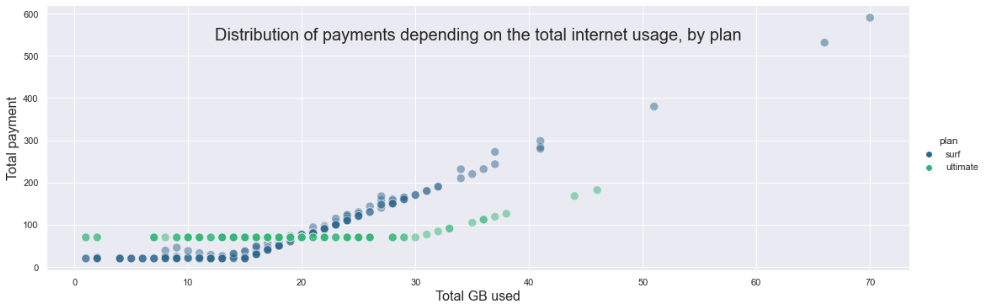

[With regard to the `NY-NJ-PA MSA`](#test3), there is not enough evidence that the revenue per user in this MSA was different from that in other MSAs, i.e. the hypothesis of equal means [was accepted](#test3_accepted).

And finaly, we illustarted the fact, that due to the higher number of the `surf` users, this payment plan had always [brought in more total revenue](#last_note). 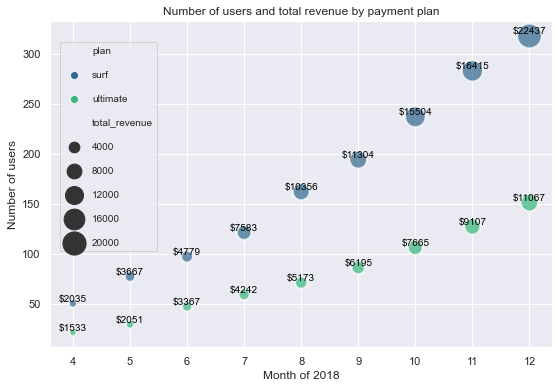

